In [68]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
import sys
from python_speech_features import mfcc
import mlp_backprop_momentum as mlp

%matplotlib inline

In [69]:
PATH = '/home/nums/Documents/MLG/lab04/vowels/'

In [70]:
# Empty array to store dataset trough iteration (sounds)
def create_dataset():
    dataset = np.array([], dtype=float).reshape(0,14)
    
    for filename in os.listdir(PATH):
        type = -1
        if(filename.startswith('nam')): #h humain
            type = 0
        elif(filename.startswith('sam')): #h syn
            type = 100
        elif (filename.startswith('naf')): #f humain
            type = 200
        elif (filename.startswith('saf')): #f syn
            type = 300
        elif (filename.startswith('nk')): #k humain
            type = 400
        elif (filename.startswith('sk5')): #k syn
            type = 500
        else:
            type = -1
        
        if(type == 0 or type == 200):
            sample_rate, X = wav.read(os.path.join(PATH, filename))
            coef = mfcc(X, samplerate=sample_rate, nfft=1024)
            coef = np.insert(coef,13,type,axis=1)
            dataset = np.append(dataset, coef,axis=0)
         
    return dataset
        
           

In [71]:
dataset = create_dataset()

In [72]:
def split_dataset(dataset, n_parts=5):
    n_rows = dataset.shape[0]
    index_all = np.arange(n_rows)
    np.random.shuffle(index_all)
    parts = []
    current_start = 0
    for p in np.arange(n_parts):
        current_end = current_start + int(np.floor(n_rows / (n_parts-p)))
        parts.append(dataset[index_all[current_start:current_end],:])
        n_rows -= current_end - current_start
        current_start = current_end
    return parts

In [73]:
split_dataset(create_dataset(),5)

[array([[ 2.06947800e+01, -1.75577297e+00, -1.94706308e+01, ...,
          1.05623024e+00, -8.35722240e+00,  0.00000000e+00],
        [ 2.11509877e+01, -2.78638018e+00,  1.34757731e+00, ...,
          4.37289355e+00,  5.70636858e+00,  2.00000000e+02],
        [ 2.17288568e+01,  4.29038447e+00, -1.41330150e+01, ...,
         -1.84837044e+01, -8.86421320e+00,  2.00000000e+02],
        ...,
        [ 2.09767220e+01,  8.91287311e-02, -2.80318616e+00, ...,
         -2.35442014e+00, -2.22132030e+00,  2.00000000e+02],
        [ 2.00765157e+01, -1.94813820e+00,  5.98853570e+00, ...,
          1.28343089e+01,  2.44315395e+00,  0.00000000e+00],
        [ 2.17982127e+01, -3.28886001e+00, -1.34414951e+01, ...,
         -5.39740659e+00,  2.24799837e+00,  2.00000000e+02]]),
 array([[ 21.46290532,   5.93090566,  -8.75655821, ...,  -7.90612243,
         -22.69180465, 200.        ],
        [ 20.78365943,  10.46344296,  -7.33327428, ...,  -5.0562989 ,
           7.77723836, 200.        ],
        [ 21.

In [74]:
def k_fold_cross_validation(mlp, dataset, K=5, learning_rate=0.01, momentum=0.7, epochs=100):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = split_dataset(dataset, K)
    
    for k in np.arange(K):
        mlp.init_weights()
        
        training_parts = set(np.arange(K))
        training_parts.remove(k)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k]

        input_data = dataset_train[:,0:nn.n_inputs]
        output_data = dataset_train[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        input_data_test = dataset_test[:,0:nn.n_inputs]
        output_data_test = dataset_test[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        
        MSE_train = mlp.fit((input_data, output_data),
                            learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        temp, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += temp
        temp, _ = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += temp

    return (MSE_train_mean / K, MSE_test_mean / K)

In [75]:
N_SPLITS = 10
EPOCHS = 20
N_NEURONS = 2
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.7
DATA_PARAMS = np.arange(0, 1)

In [76]:
MSE_train = np.zeros((len(DATA_PARAMS), N_SPLITS))
MSE_test = np.zeros((len(DATA_PARAMS), N_SPLITS))
nn = mlp.MLP([2,N_NEURONS,1], 'tanh')

print('Testing dataset')
dataset = create_dataset()

for d in np.arange(N_SPLITS):                                       # looping the splits
    sys.stdout.write('.')

    temp1, temp2 = k_fold_cross_validation(nn,
                                           dataset,
                                           K=K,
                                           learning_rate=LEARNING_RATE,
                                           momentum=MOMENTUM,
                                           epochs=EPOCHS)
    MSE_train[0,d] = temp1
    MSE_test[0,d] = temp2

print(N_SPLITS, ' tests done')

Testing dataset
..........10  tests done


In [77]:
datasetH = np.array([], dtype=float).reshape(0,14)
datasetF = np.array([], dtype=float).reshape(0,14)

datasetH = np.vstack((datasetH, dataset[dataset[:,13] == 0])) #h humain
datasetF = np.vstack((datasetF, dataset[dataset[:,13] == 200])) #f humain       

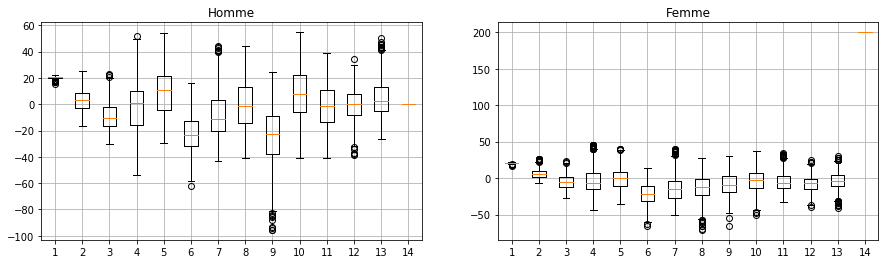

In [78]:
pl.figure(figsize=(15,4))
pl.subplot(1,2,1)
pl.boxplot(datasetH)
pl.title('Homme')
pl.grid()
pl.subplot(1,2,2)
pl.boxplot(datasetF)
pl.title('Femme')
pl.grid()